<a href="https://colab.research.google.com/github/ayanali827/TriNav-Tri-Layer-Navigation-A-DWA-MPC-/blob/main/Copy_of_MLR_PhysCons_Pract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physically Consistent Deep Learning



In [ ]:
import torch
from torch.func import jacrev, hessian, vmap
import matplotlib.pyplot as plt
import time
import numpy as np

## Task 1: ODE solution

Find $y(x)$ that satisfies $\mathcal{N}[y,x] = \frac{d^2 y}{d x^2} + y = 0$

### Prepare Data

We first prepare a dataset $\{(x,y)\}$ that satisfies the DE
The dataset has very few datapoints (to test data efficiency) and with noise (to test robustness)

In [ ]:
# Generation of synthetic dataset
def generate_data(interval = (-torch.pi, torch.pi), num_samples= 1000, A = 1.0, phi = 0.0):
  X = (interval[1]-interval[0]) * torch.rand((num_samples, 1), requires_grad= True) + interval[0]

  f = lambda x : A*torch.cos(x + phi)
  Y = f(X)
  print(f"Generated dataset with {num_samples} samples, x in interval [{X.min().item():.2f}, {X.max().item():.2f}], y(x) = {A:.2f} cos(x {phi:+.2f})")

  # check if the differential equation N[y,x] = 0 holds

  ## compute first derivative (jacobian)
  df_dx = vmap(jacrev(f))
  dY_dX = df_dx(X).reshape(Y.shape)

  ## compute second derivative (hessian)
  d2f_dx2 = vmap(hessian(f))
  d2Y_dX2 = d2f_dx2(X).reshape(Y.shape)

  ## compute N[y,x]
  N = d2Y_dX2 + Y
  if torch.allclose(torch.mean(torch.square(N)), torch.tensor(0.)) :
    print("Differential equation holds")
  else:
    print("Something went wrong, Differential equation doesn't hold")
  return (X,Y)

def generate_train_test(interval_train, num_samples_train, interval_test, num_samples_test):
  A = 3* torch.rand(()) + 1 # random number between [1, 4]
  phi = 2 * torch.pi * torch.rand(()) - torch.pi # random number between [-pi, pi]
  return generate_data(interval_train, num_samples_train, A, phi), generate_data(interval_test, num_samples_test, A, phi)


# very few data points + noise
# range of test data is wider to test generalization to unseen scenarios
# 50 points for training |
(X_train, Y_train), (X_test, Y_test) = generate_train_test([-5, 5], 50, [-10, 10], 1000)
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

Generated dataset with 50 samples, x in interval [-4.94, 4.99], y(x) = 2.48 cos(x -2.23)
Differential equation holds
Generated dataset with 1000 samples, x in interval [-9.99, 10.00], y(x) = 2.48 cos(x -2.23)
Differential equation holds


### Prepare the model $f_{NN}(x; \theta)$ and its derivatives


- `vmap` is the vectorization map operator, it takes a function and gives a batched version of the same function. If $f: \mathbb{R} \rightarrow \mathbb{R}$. Then $\text{vmap}(f) =  f' : \mathbb{R^{n}} → \mathbb{R^{n}}$
- `jacrev` is the jacobian operator (using reverse autograd), it takes a function $f(x)$ and gives a function $\frac{\partial f}{\partial x} (x)$.
- `hessian` is the hessian operator, it takes a function $f(x)$ and gives a function $\frac{\partial^2 f}{\partial x^2} (x)$.

These functions are part of the functional API of PyTorch that is similar to JAX.

In [ ]:
def get_model_and_derivatives(hidden_channels = (64, 64), activation = torch.nn.GELU, device= "cpu"):
  # construct a simple MLP
  layers = []
  inp = 1
  for h in hidden_channels:
      layers.append(torch.nn.Linear(inp, h))
      layers.append(activation())
      inp = h
  layers.append(torch.nn.Linear(inp, 1))
  model =  torch.nn.Sequential(*layers).to(device)

  # functions to compute the output and its derivatives
  # we use functions because jacrev, hessian, vmap ... requires a function and not nn.Module
  # that's why the API is called "functional"
  f = lambda x : model(x)
  df_dx = vmap(jacrev(f))
  d2f_dx2 = vmap(hessian(f))

  return (f, df_dx, d2f_dx2), model.parameters()

### Testing routine

In [ ]:
def test_model(f, X, Y):
  # simple check for f(X) vs Y,
  print(f"MSE: {torch.nn.functional.mse_loss(f(X), Y)}")
  sorted_indices = torch.argsort(X.flatten())
  X = X[sorted_indices].reshape(-1,1)
  Y = Y[sorted_indices].reshape(-1,1)
  plt.plot(X.detach().cpu(), Y.detach().cpu(), label= 'Act')
  plt.plot(X.detach().cpu(), f(X).detach().cpu(), label= 'Pred')
  plt.legend()
  plt.plot()

### Train a black-box deep learning model

t: 0.20, Epoch 100: MSE: 0.0155, LR: 0.009649
t: 0.33, Epoch 200: MSE: 0.0138, LR: 0.008644
t: 0.46, Epoch 300: MSE: 0.0136, LR: 0.007127
t: 0.63, Epoch 400: MSE: 0.0134, LR: 0.005311
t: 0.80, Epoch 500: MSE: 0.0133, LR: 0.003451
t: 0.97, Epoch 600: MSE: 0.0133, LR: 0.001809
t: 1.16, Epoch 700: MSE: 0.0132, LR: 0.000616
t: 1.32, Epoch 800: MSE: 0.0132, LR: 0.000039
t: 1.53, Epoch 900: MSE: 0.0132, LR: 0.000159
t: 1.68, Epoch 1000: MSE: 0.0132, LR: 0.000959
t: 1.84, Epoch 1100: MSE: 0.0132, LR: 0.002328
t: 1.99, Epoch 1200: MSE: 0.0131, LR: 0.004072
t: 2.17, Epoch 1300: MSE: 0.0131, LR: 0.005947
t: 2.33, Epoch 1400: MSE: 0.0131, LR: 0.007688
t: 2.52, Epoch 1500: MSE: 0.0129, LR: 0.009052
t: 2.72, Epoch 1600: MSE: 0.0175, LR: 0.009846
t: 2.84, Epoch 1700: MSE: 0.0125, LR: 0.009959
t: 2.96, Epoch 1800: MSE: 0.0120, LR: 0.009375
t: 3.08, Epoch 1900: MSE: 0.0117, LR: 0.008176
t: 3.20, Epoch 2000: MSE: 0.0115, LR: 0.006531
t: 3.32, Epoch 2100: MSE: 0.0114, LR: 0.004670
t: 3.44, Epoch 2200: M

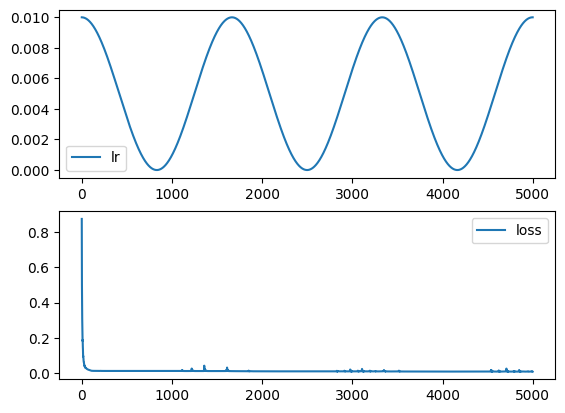

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, _), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
# We use a CosineAnnealingLR scheduler to help avoid local minima
# it helps excite the training process which could pull the weights from
# a gradient local minima

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()

  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss = loss_mse
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time()-start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.009832976385951042


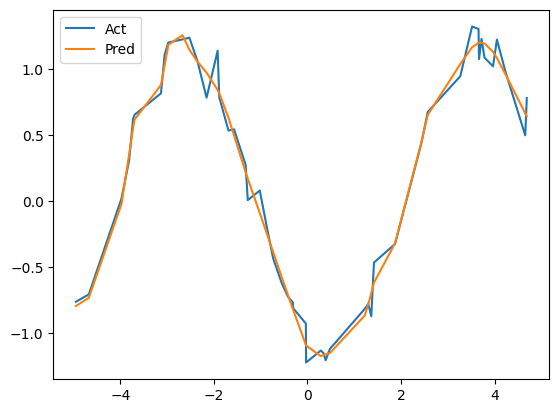

In [ ]:
test_model(f, X_train, Y_train)

MSE: 1.6213351488113403


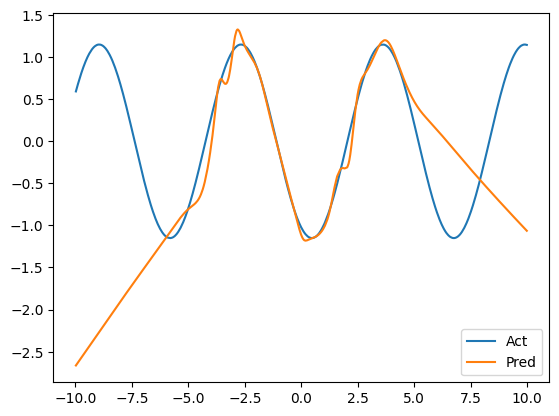

In [ ]:
test_model(f, X_test, Y_test)

We can see signs for overfitting and poor generlization

### Train a PINN deep learning model

t: 0.88, Epoch 100: MSE: 0.0156, Phys: 0.0068, LR: 0.003419
t: 1.73, Epoch 200: MSE: 0.0152, Phys: 0.0042, LR: 0.001000
t: 2.59, Epoch 300: MSE: 0.0157, Phys: 0.0024, LR: 0.009111
t: 3.45, Epoch 400: MSE: 0.0145, Phys: 0.0011, LR: 0.006400
t: 4.30, Epoch 500: MSE: 0.0145, Phys: 0.0010, LR: 0.000004
t: 5.37, Epoch 600: MSE: 0.0145, Phys: 0.0008, LR: 0.006759
t: 6.52, Epoch 700: MSE: 0.0145, Phys: 0.0006, LR: 0.008884
t: 7.67, Epoch 800: MSE: 0.0144, Phys: 0.0005, LR: 0.000784
t: 8.52, Epoch 900: MSE: 0.0144, Phys: 0.0005, LR: 0.003782
t: 9.35, Epoch 1000: MSE: 0.0143, Phys: 0.0003, LR: 0.009986


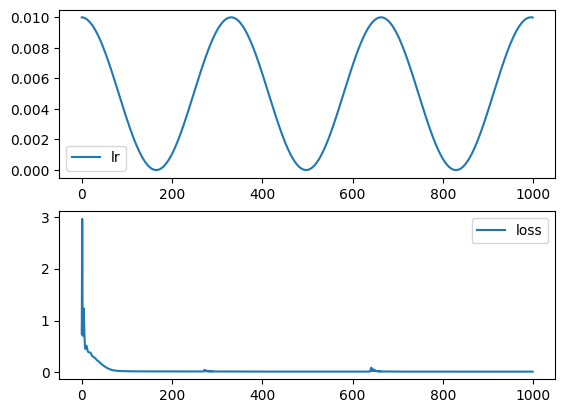

In [ ]:
lr = 0.01
num_epochs = 1000
T_scheduler = num_epochs // 6
coeff_phys = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)


  # we add a loss function for the constraint d2y_dx2 - y = 0
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_phys = loss_fun(d2Y_dX2_pred, -Y_pred)
  #
  loss = loss_mse + coeff_phys * loss_phys
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.014338536188006401


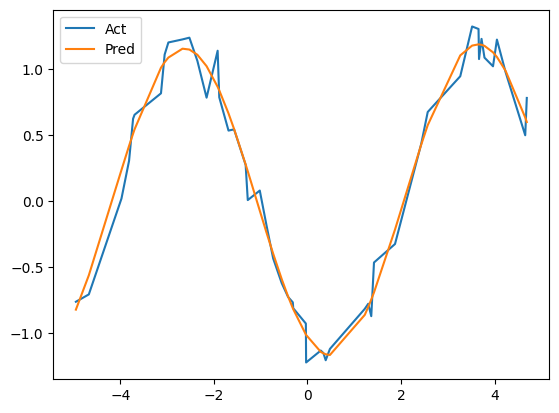

In [ ]:
test_model(f, X_train, Y_train)

MSE: 2.8811964988708496


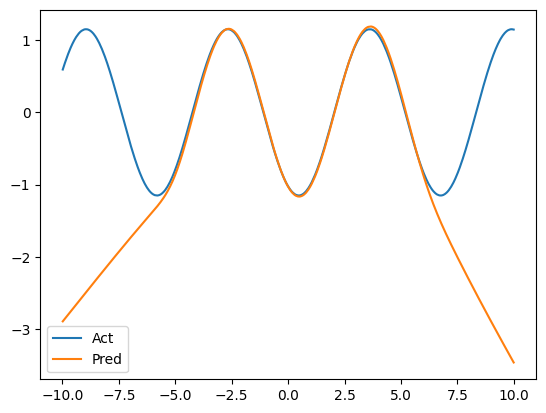

In [ ]:
test_model(f, X_test, Y_test)

We can already see that the physica loss has regulerization effect, even with noisy data, the physical constraint decreased overfitting

### Train a PINN deep learning model - 2nd try

We will use extra data points $x$ that we don't $y$ for. However, we know that $\frac{\partial^2 f}{\partial x^2}(x) - f(x) = 0$  

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
coeff_phys1 = 1.0
coeff_phys2 = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# dummy data in [-10, 10] interval
X_dummy = torch.arange(-10, 10, 0.01).to(device).reshape(-1,1)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss_phys1 = loss_fun(d2Y_dX2_pred, -Y_pred)

  # physics loss using dummy data (no Y available)
  Y_pred_dummy = f(X_dummy)
  d2Y_dX2_pred_dummy = d2f_dx2(X_dummy).reshape(-1,1)
  loss_phys2 = loss_fun(d2Y_dX2_pred_dummy, -Y_pred_dummy)

  loss = loss_mse + coeff_phys1 * loss_phys1 + coeff_phys2 * loss_phys2

  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch: {epoch+1}: MSE: {loss_mse.item():.4f}, Phys1: {loss_phys1.item():.4f},Phys2: {loss_phys2.item():.4f},  LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


In [ ]:
test_model(f, X_train, Y_train)

In [ ]:
test_model(f, X_test, Y_test)

We can see that even with only 50 noisy data points on [-5, 5] range, we are able to predict well outisde that range.

HW 1:

Suggest other constraint that can be done using dummy data, something related to the periodic nature maybe?. Implement your suggestion and produce graphs. Comment on them

t: 5.82, Epoch: 100: MSE: 0.2064, Phys1: 0.0271,Phys2: 0.0269,  LR: 0.009649
t: 12.20, Epoch: 200: MSE: 0.0980, Phys1: 0.0080,Phys2: 0.0271,  LR: 0.008644
t: 18.22, Epoch: 300: MSE: 0.0425, Phys1: 0.0023,Phys2: 0.0386,  LR: 0.007127
t: 25.07, Epoch: 400: MSE: 0.0368, Phys1: 0.0023,Phys2: 0.0373,  LR: 0.005311
t: 31.89, Epoch: 500: MSE: 0.0326, Phys1: 0.0017,Phys2: 0.0360,  LR: 0.003451
t: 38.41, Epoch: 600: MSE: 0.0304, Phys1: 0.0015,Phys2: 0.0336,  LR: 0.001809
t: 44.28, Epoch: 700: MSE: 0.0291, Phys1: 0.0014,Phys2: 0.0316,  LR: 0.000616
t: 50.64, Epoch: 800: MSE: 0.0287, Phys1: 0.0013,Phys2: 0.0309,  LR: 0.000039
t: 56.43, Epoch: 900: MSE: 0.0287, Phys1: 0.0013,Phys2: 0.0308,  LR: 0.000159
t: 63.05, Epoch: 1000: MSE: 0.0278, Phys1: 0.0013,Phys2: 0.0292,  LR: 0.000959
t: 69.00, Epoch: 1100: MSE: 0.0206, Phys1: 0.0020,Phys2: 0.0243,  LR: 0.002328
t: 75.51, Epoch: 1200: MSE: 0.0200, Phys1: 0.0007,Phys2: 0.0137,  LR: 0.004072
t: 81.54, Epoch: 1300: MSE: 0.0175, Phys1: 0.0004,Phys2: 0.007

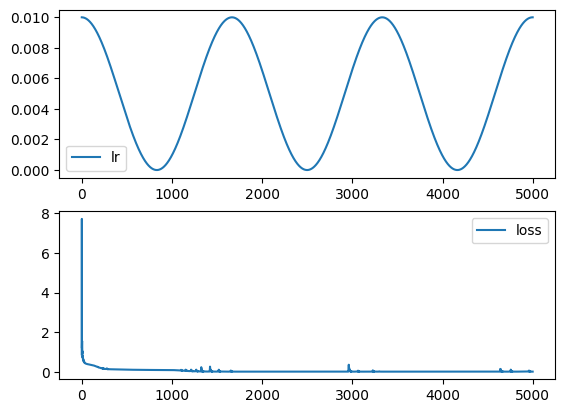

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
coeff_phys1 = 1.0
coeff_phys2 = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, df_dx, d2f_dx2), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []
losses_periodic = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# dummy data in [-10, 10] interval
X_dummy = torch.arange(-10, 10, 0.01).to(device).reshape(-1,1)
period = 2 * torch.pi
X_periodic = (X_dummy + period) % (2 * torch.pi)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss_phys1 = loss_fun(d2Y_dX2_pred, -Y_pred)

  # physics loss using dummy data (no Y available)
  Y_pred_dummy = f(X_dummy)
  d2Y_dX2_pred_dummy = d2f_dx2(X_dummy).reshape(-1,1)
  loss_phys2 = loss_fun(d2Y_dX2_pred_dummy, -Y_pred_dummy)

  # periodic boundary condition loss
  Y_pred_periodic = f(X_periodic)
  dY_dX_dummy = df_dx(X_dummy).reshape(-1,1)
  dY_dX_periodic = df_dx(X_periodic).reshape(-1,1)

  # compute periodic loss
  loss_periodic = loss_fun(Y_pred_periodic, Y_pred_dummy) + loss_fun(dY_dX_periodic, dY_dX_dummy)

  # total loss
  loss = loss_mse + coeff_phys1 * loss_phys1 + coeff_phys2 * loss_phys2 + 0.5 * loss_periodic


  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch: {epoch+1}: MSE: {loss_mse.item():.4f}, Phys1: {loss_phys1.item():.4f},Phys2: {loss_phys2.item():.4f},  LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.014826527796685696


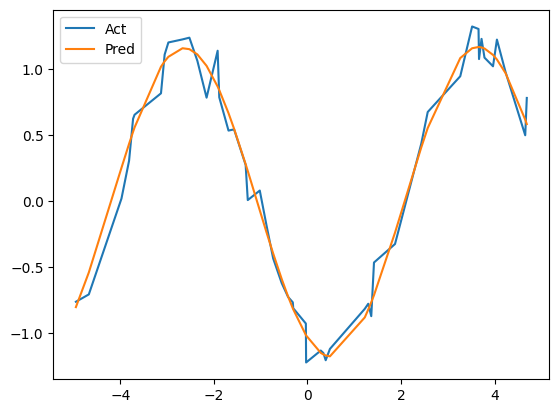

In [ ]:
test_model(f, X_train, Y_train)

MSE: 0.001025776262395084


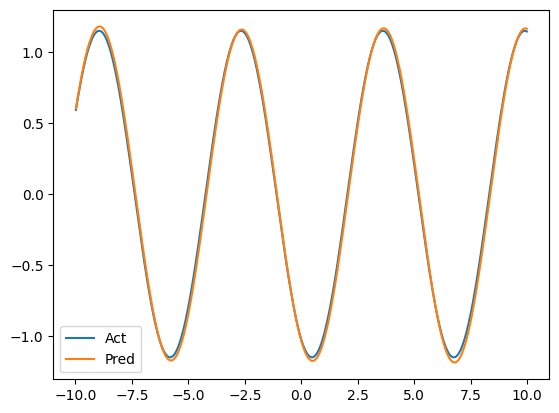

In [ ]:
test_model(f, X_test, Y_test)

We can see that even with only 50 noisy data points on [-5, 5] range, we are able to predict well outisde that range.

## HW 1:
Suggest other constraint that can be done using dummy data, something related to the periodic nature maybe?. Implement your suggestion and produce graphs. Comment on them


## ODE discovery
Find $y(x)$ that satisfies $\mathcal{N}[y,x; \omega] = \frac{d^2 y}{d x^2} + \omega ^2 y = 0$, $\omega$ is unknown

### Prepare Data

As before, but with different frequency $\omega = 1.5$ is unknown to the model, it should be learnt

In [ ]:
# Generation of synthetic dataset
def generate_data(interval = (-torch.pi, torch.pi), num_samples= 1000, A = 1.0, phi = 0.0, omega= 1.5):
  X = (interval[1]-interval[0]) * torch.rand((num_samples, 1), requires_grad= True) + interval[0]

  f = lambda x : A*torch.cos(omega* x + phi)
  Y = f(X)
  print(f"Generated dataset with {num_samples} samples, x in interval [{X.min().item():.2f}, {X.max().item():.2f}], y(x) = {A:.2f} cos({omega:.2f} x {phi:+.2f})")

  # check if the differential equation N[y,x] = 0 holds

  ## compute first derivative (jacobian)
  df_dx = vmap(jacrev(f))
  dY_dX = df_dx(X).reshape(Y.shape)

  ## compute second derivative (hessian)
  d2f_dx2 = vmap(hessian(f))
  d2Y_dX2 = d2f_dx2(X).reshape(Y.shape)

  ## compute N[y,x]
  N = d2Y_dX2 + omega * omega * Y
  if torch.allclose(torch.mean(torch.square(N)), torch.tensor(0.)) :
    print("Differential equation holds")
  else:
    print("Something went wrong, Differential equation doesn't hold")
  return (X,Y)
def generate_train_test(interval_train, num_samples_train, interval_test, num_samples_test, omega):
  A = 3* torch.rand(()) + 1 # random number between [1, 4]
  phi = 2 * torch.pi * torch.rand(()) - torch.pi # random number between [-pi, pi]
  return generate_data(interval_train, num_samples_train, A, phi, omega), generate_data(interval_test, num_samples_test, A, phi)


# very few data points + noise
(X_train, Y_train), (X_test, Y_test) = generate_train_test([-5, 5], 50, [-10, 10], 1000, 1.5)
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

Generated dataset with 50 samples, x in interval [-4.91, 4.78], y(x) = 2.61 cos(1.50 x -1.43)


NameError: name 'vmap' is not defined

### Black Box DL model

t: 0.12, Epoch 100: MSE: 0.0712, LR: 0.009649
t: 0.24, Epoch 200: MSE: 0.0662, LR: 0.008644
t: 0.37, Epoch 300: MSE: 0.0647, LR: 0.007127
t: 0.49, Epoch 400: MSE: 0.0634, LR: 0.005311
t: 0.61, Epoch 500: MSE: 0.0621, LR: 0.003451
t: 0.73, Epoch 600: MSE: 0.0611, LR: 0.001809
t: 0.86, Epoch 700: MSE: 0.0605, LR: 0.000616
t: 0.99, Epoch 800: MSE: 0.0604, LR: 0.000039
t: 1.11, Epoch 900: MSE: 0.0604, LR: 0.000159
t: 1.23, Epoch 1000: MSE: 0.0600, LR: 0.000959
t: 1.36, Epoch 1100: MSE: 0.0588, LR: 0.002328
t: 1.53, Epoch 1200: MSE: 0.0572, LR: 0.004072
t: 1.70, Epoch 1300: MSE: 0.1317, LR: 0.005947
t: 1.87, Epoch 1400: MSE: 0.0790, LR: 0.007688
t: 2.04, Epoch 1500: MSE: 0.0541, LR: 0.009052
t: 2.19, Epoch 1600: MSE: 0.0487, LR: 0.009846
t: 2.35, Epoch 1700: MSE: 0.0466, LR: 0.009959
t: 2.51, Epoch 1800: MSE: 0.0498, LR: 0.009375
t: 2.66, Epoch 1900: MSE: 0.0420, LR: 0.008176
t: 2.83, Epoch 2000: MSE: 0.0401, LR: 0.006531
t: 3.01, Epoch 2100: MSE: 0.0388, LR: 0.004670
t: 3.19, Epoch 2200: M

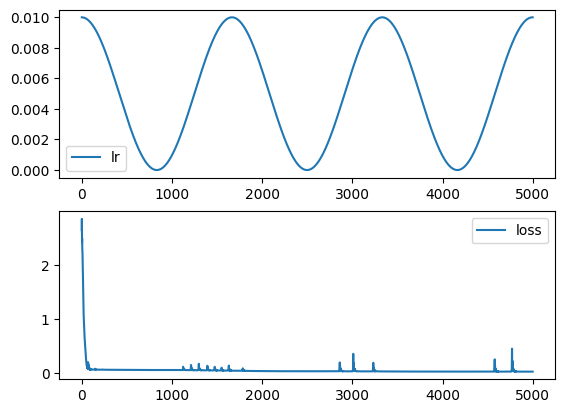

In [ ]:
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, _), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)


lrs = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  loss_mse = loss_fun(Y_train, Y_pred)
  loss = loss_mse
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time()-start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.03281332179903984


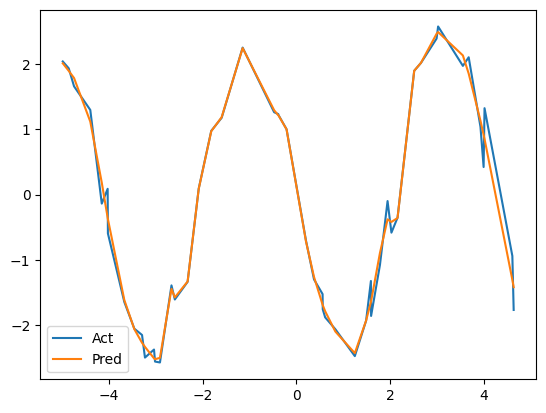

In [ ]:
test_model(f, X_train, Y_train)

MSE: 27.467443466186523


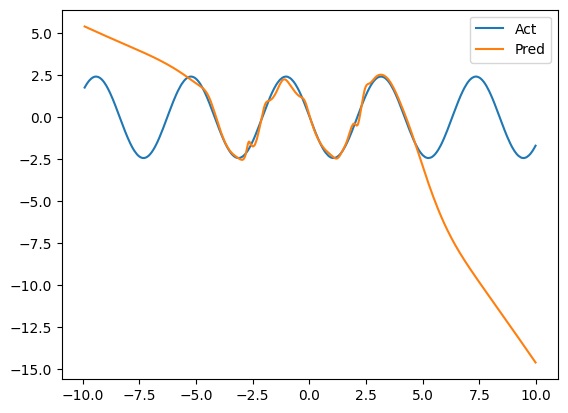

In [ ]:
test_model(f, X_test, Y_test)

We see similar behaviour as before, overfitting + poor generalization to unseen scenarios.

### PINN model: 1st try
We add a learnable parameter $\omega$.

t: 0.89, Epoch 100: MSE: 0.2425, Phys: 0.1713, LR: 0.008536, Omega: 1.27
t: 1.77, Epoch 200: MSE: 0.1063, Phys: 0.0211, LR: 0.005000, Omega: 1.37
t: 2.63, Epoch 300: MSE: 0.0865, Phys: 0.0093, LR: 0.001464, Omega: 1.41
t: 3.53, Epoch 400: MSE: 0.0845, Phys: 0.0083, LR: 0.000000, Omega: 1.42
t: 4.42, Epoch 500: MSE: 0.0826, Phys: 0.0074, LR: 0.001464, Omega: 1.42
t: 5.29, Epoch 600: MSE: 0.0793, Phys: 0.0063, LR: 0.005000, Omega: 1.44
t: 6.17, Epoch 700: MSE: 0.0759, Phys: 0.0052, LR: 0.008536, Omega: 1.46
t: 7.20, Epoch 800: MSE: 0.0754, Phys: 0.0056, LR: 0.010000, Omega: 1.46
t: 8.41, Epoch 900: MSE: 0.0735, Phys: 0.0016, LR: 0.008536, Omega: 1.48
t: 9.38, Epoch 1000: MSE: 0.0732, Phys: 0.0014, LR: 0.005000, Omega: 1.48
t: 10.23, Epoch 1100: MSE: 0.0731, Phys: 0.0013, LR: 0.001464, Omega: 1.48
t: 11.09, Epoch 1200: MSE: 0.0731, Phys: 0.0013, LR: 0.000000, Omega: 1.48
t: 11.95, Epoch 1300: MSE: 0.0730, Phys: 0.0013, LR: 0.001464, Omega: 1.48
t: 12.78, Epoch 1400: MSE: 0.0730, Phys: 0.0

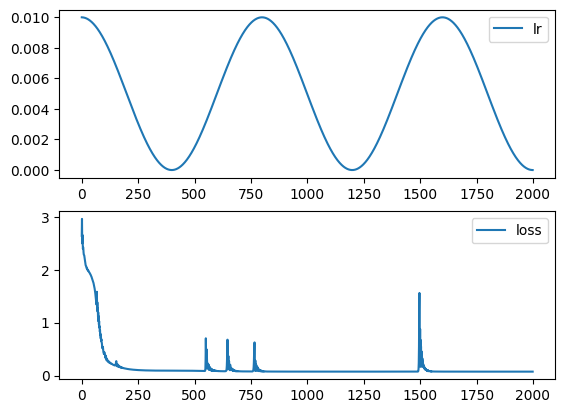

In [ ]:
# Learnable Parameter
omega_t = torch.tensor(0.01, requires_grad=True) #requires_grad is important so torch will generate gradients for this

lr = 0.01
num_epochs = 2000
T_scheduler = num_epochs // 5
coeff_phys = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
params = [*params, omega_t] # the total set of parameters are model_parameters + omega
optim = torch.optim.Adam(params, lr= lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

start_time = time.time()
for epoch in range(num_epochs):
  optim.zero_grad()
  Y_pred = f(X_train)
  d2Y_dX2_pred = d2f_dx2(X_train).reshape(-1,1)
  loss_mse = loss_fun(Y_train, Y_pred)
  # attention to the loss formula taking into account omega
  loss_phys = loss_fun(d2Y_dX2_pred, -omega_t*omega_t*Y_pred)
  loss = loss_mse + coeff_phys * loss_phys
  loss.backward(retain_graph= True)
  optim.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
  losses_mse.append(loss_mse.item())
  losses_phys.append(loss_phys.item())
  losses.append(loss.item())
  if (epoch + 1)%100 == 0:
    print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}, Omega: {omega_t.item():.2f}")

plt.subplot(2, 1, 1)
plt.plot(lrs, label= 'lr')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses, label= 'loss')
plt.legend()
plt.show()


MSE: 0.17037968337535858


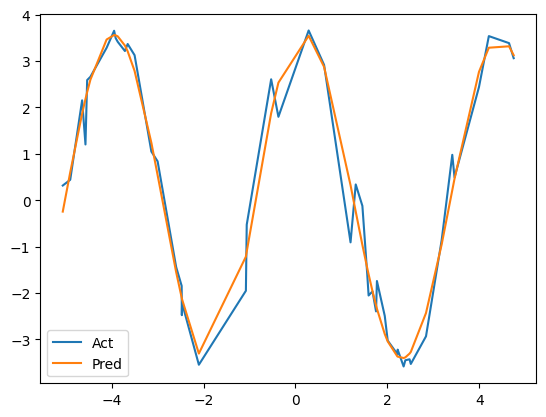

In [ ]:
test_model(f, X_train, Y_train)

MSE: 53.45041275024414


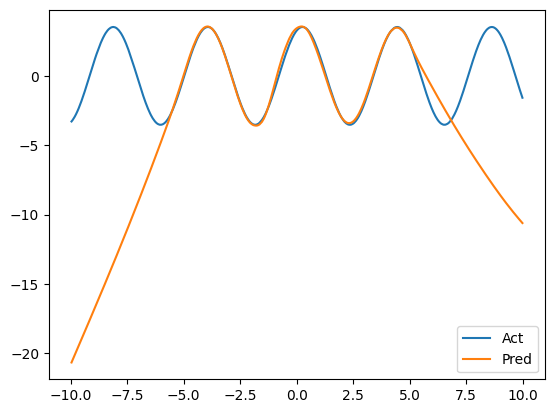

In [ ]:
test_model(f, X_test, Y_test)

## HW2:
Implement PINNs with dummy data to enhance generalization, plot graphs



t: 3.19, Epoch 100: MSE: 1.1859, Phys: 0.4827, LR: 0.006829, Omega: 0.24
t: 6.69, Epoch 200: MSE: 1.1712, Phys: 0.4808, LR: 0.006332, Omega: 0.31
t: 10.38, Epoch 300: MSE: 0.3281, Phys: 0.4355, LR: 0.005557, Omega: 1.42
t: 13.70, Epoch 400: MSE: 0.2439, Phys: 0.3486, LR: 0.004582, Omega: 1.45
t: 17.00, Epoch 500: MSE: 0.1762, Phys: 0.2920, LR: 0.003500, Omega: 1.45
t: 20.94, Epoch 600: MSE: 0.1581, Phys: 0.2709, LR: 0.002418, Omega: 1.44
t: 24.29, Epoch 700: MSE: 0.1539, Phys: 0.2621, LR: 0.001443, Omega: 1.43
t: 27.54, Epoch 800: MSE: 0.1531, Phys: 0.2583, LR: 0.000668, Omega: 1.43
t: 31.10, Epoch 900: MSE: 0.1528, Phys: 0.2570, LR: 0.000171, Omega: 1.43
t: 34.66, Epoch 1000: MSE: 0.1528, Phys: 0.2568, LR: 0.000000, Omega: 1.43
t: 37.95, Epoch 1100: MSE: 0.1528, Phys: 0.2566, LR: 0.000171, Omega: 1.43
t: 41.19, Epoch 1200: MSE: 0.1525, Phys: 0.2552, LR: 0.000668, Omega: 1.43
t: 45.15, Epoch 1300: MSE: 0.1529, Phys: 0.2520, LR: 0.001443, Omega: 1.42
t: 48.50, Epoch 1400: MSE: 0.1673, P

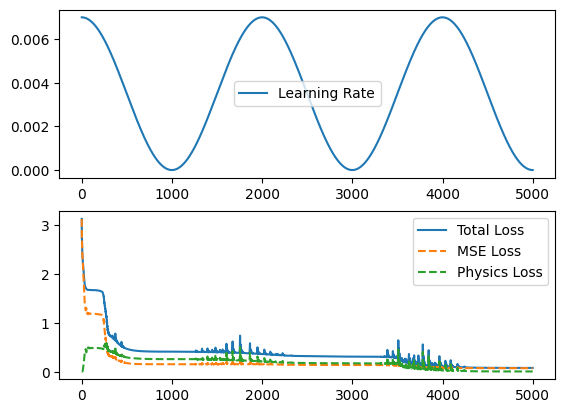

In [ ]:
# --- Step 0: Setup ---
omega_t = torch.tensor(0.1, requires_grad=True)  # learnable omega

lr = 0.007
num_epochs = 5000
T_scheduler = num_epochs // 5
coeff_phys = 1.0
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
params = [*params, omega_t]  # total set of parameters
optim = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

lrs = []
losses_mse = []
losses_phys = []
losses_total = []

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# --- Step 1: Dummy data for physics loss ---
X_dummy = torch.arange(-10, 10, 0.01).reshape(-1, 1).to(device)

# --- Step 2: Training Loop ---
start_time = time.time()
for epoch in range(num_epochs):
    optim.zero_grad()

    # ---- Data loss ----
    Y_pred = f(X_train)
    loss_mse = loss_fun(Y_train, Y_pred)

    # ---- Physics loss ----
    Y_dummy_pred = f(X_dummy)
    d2Y_dummy_pred = d2f_dx2(X_dummy).reshape(-1, 1)
    loss_phys = loss_fun(d2Y_dummy_pred, -omega_t * omega_t * Y_dummy_pred)

    # ---- Total loss ----
    loss = loss_mse + coeff_phys * loss_phys

    # ---- Backpropagation ----
    loss.backward(retain_graph=True)
    optim.step()
    scheduler.step()

    lrs.append(scheduler.get_last_lr()[0])
    losses_mse.append(loss_mse.item())
    losses_phys.append(loss_phys.item())
    losses_total.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"t: {time.time() - start_time:.2f}, Epoch {epoch+1}: "
              f"MSE: {loss_mse.item():.4f}, Phys: {loss_phys.item():.4f}, "
              f"LR: {scheduler.get_last_lr()[0]:.6f}, Omega: {omega_t.item():.2f}")

# --- Step 3: Plot Losses ---
plt.subplot(2, 1, 1)
plt.plot(lrs, label='Learning Rate')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(losses_total, label='Total Loss')
plt.plot(losses_mse, '--', label='MSE Loss')
plt.plot(losses_phys, '--', label='Physics Loss')
plt.legend()
plt.show()


MSE: 0.07239306718111038


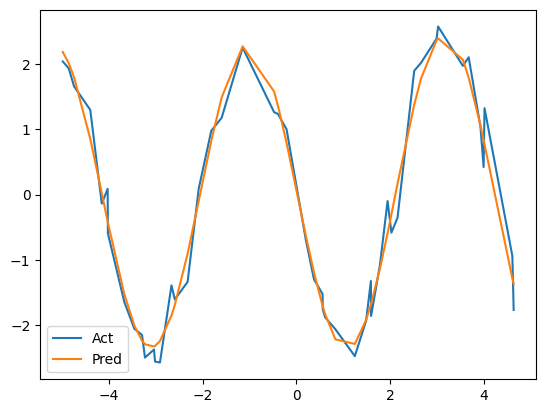

In [ ]:
test_model(f, X_train, Y_train)

MSE: 0.009963628835976124


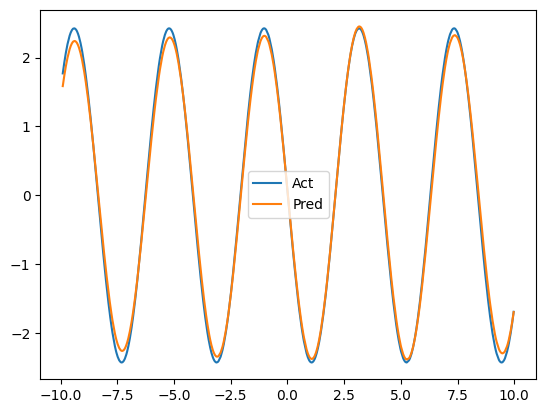

In [ ]:
test_model(f, X_test, Y_test)

## HW3:

Now we explored the case of full known DE and the case of unknown frequency. Now implement the case of unknown frequency + unknown bias, something like $y(x) = A cos(\omega x + \phi) + B$. First derive the DE operator $N$ and implement PINNs to discover and solve it.  

True parameters: A=2.489, phi=1.685, omega=1.500, B=0.700
DE holds (checked on true function).
DE holds (checked on true function).
t=0.16s, Epoch 100: MSE=0.0482, LR=0.009649
t=0.31s, Epoch 200: MSE=0.0421, LR=0.008644
t=0.46s, Epoch 300: MSE=0.0375, LR=0.007127
t=0.61s, Epoch 400: MSE=0.0340, LR=0.005311
t=0.78s, Epoch 500: MSE=0.0319, LR=0.003451
t=0.93s, Epoch 600: MSE=0.0309, LR=0.001809
t=1.08s, Epoch 700: MSE=0.0305, LR=0.000616
t=1.24s, Epoch 800: MSE=0.0304, LR=0.000039
t=1.40s, Epoch 900: MSE=0.0304, LR=0.000159
t=1.55s, Epoch 1000: MSE=0.0302, LR=0.000959
t=1.71s, Epoch 1100: MSE=0.0302, LR=0.002328
t=1.88s, Epoch 1200: MSE=0.0591, LR=0.004072
t=2.03s, Epoch 1300: MSE=0.0986, LR=0.005947
t=2.20s, Epoch 1400: MSE=0.0278, LR=0.007688
t=2.35s, Epoch 1500: MSE=0.0272, LR=0.009052
t=2.50s, Epoch 1600: MSE=0.0365, LR=0.009846
t=2.66s, Epoch 1700: MSE=0.0257, LR=0.009959
t=2.83s, Epoch 1800: MSE=0.0246, LR=0.009375
t=2.99s, Epoch 1900: MSE=0.0238, LR=0.008176
t=3.15s, Epoch 2000: M

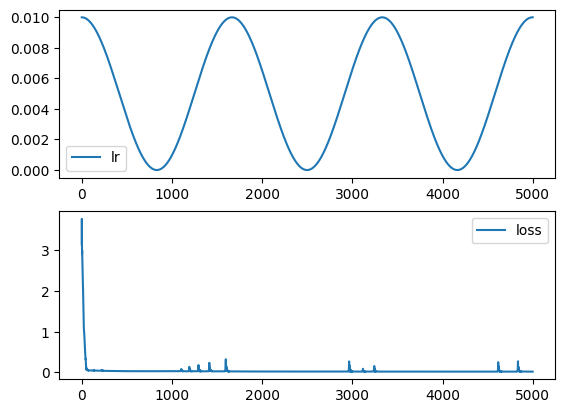

In [ ]:
# HW3_PINN_omega_B_reference_style.py
import torch
from torch.func import jacrev, hessian, vmap
import matplotlib.pyplot as plt
import time
import math
torch.manual_seed(0)

# --------------------------------------------
# Model + derivatives
# --------------------------------------------
def get_model_and_derivatives(hidden_channels=(64, 64), activation=torch.nn.GELU, device="cpu"):
    layers = []
    inp = 1
    for h in hidden_channels:
        layers.append(torch.nn.Linear(inp, h))
        layers.append(activation())
        inp = h
    layers.append(torch.nn.Linear(inp, 1))
    model = torch.nn.Sequential(*layers).to(device)

    f = lambda x: model(x)
    df_dx = vmap(jacrev(f))
    d2f_dx2 = vmap(hessian(f))

    return (f, df_dx, d2f_dx2), model.parameters()

# --------------------------------------------
# Generate synthetic data with cosine + bias
# --------------------------------------------
def generate_data(interval=(-math.pi, math.pi), num_samples=1000, A=1.0, phi=0.0, omega=1.5, B=0.7):
    X = (interval[1] - interval[0]) * torch.rand((num_samples, 1), requires_grad=True) + interval[0]
    f_true = lambda x: A * torch.cos(omega * x + phi) + B
    Y = f_true(X)

    # Check DE: y'' + omega^2*(y-B) ≈ 0
    d2Y = vmap(hessian(lambda x: A * torch.cos(omega * x + phi)))(X).reshape(Y.shape)
    residual = d2Y + omega**2 * (Y - B)
    mse_residual = torch.mean(residual**2).item()

    if torch.allclose(torch.mean(residual**2), torch.tensor(0.), atol=1e-6):
        print("DE holds (checked on true function).")
    else:
        print(f"Warning: DE residual not zero (MSE={mse_residual:.6e})")

    return X, Y

# --------------------------------------------
# Generate training and test sets
# --------------------------------------------
def generate_train_test(interval_train, num_samples_train, interval_test, num_samples_test, omega, B):
    A = 3 * torch.rand(()) + 1                # amplitude in [1,4]
    phi = 2 * torch.pi * torch.rand(()) - torch.pi  # phase in [-pi, pi]
    print(f"True parameters: A={A.item():.3f}, phi={phi.item():.3f}, omega={omega:.3f}, B={B:.3f}")

    train_data = generate_data(interval_train, num_samples_train, A, phi, omega, B)
    test_data = generate_data(interval_test, num_samples_test, A, phi, omega, B)
    return train_data, test_data

# --------------------------------------------
# Create noisy training and test datasets
# --------------------------------------------
(X_train, Y_train), (X_test, Y_test) = generate_train_test([-5,5], 50, [-10,10], 1000, omega=1.5, B=0.7)

# Add Gaussian noise
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

# --------------------------------------------
# Training: simple MLP first
# --------------------------------------------
lr = 0.01
num_epochs = 5000
T_scheduler = num_epochs // 6
device = "cpu"
loss_fun = torch.nn.MSELoss()

(f, _, _), params = get_model_and_derivatives(device=device)
optim = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

lrs, losses = [], []

start_time = time.time()
for epoch in range(num_epochs):
    optim.zero_grad()
    Y_pred = f(X_train)
    loss_mse = loss_fun(Y_train, Y_pred)
    loss_mse.backward(retain_graph=True)
    optim.step()
    scheduler.step()

    lrs.append(scheduler.get_last_lr()[0])
    losses.append(loss_mse.item())

    if (epoch + 1) % 100 == 0:
        print(f"t={time.time()-start_time:.2f}s, Epoch {epoch+1}: MSE={loss_mse.item():.4f}, LR={scheduler.get_last_lr()[0]:.6f}")

plt.subplot(2,1,1)
plt.plot(lrs, label='lr')
plt.legend()
plt.subplot(2,1,2)
plt.plot(losses, label='loss')
plt.legend()
plt.show()




MSE: 0.020257174968719482


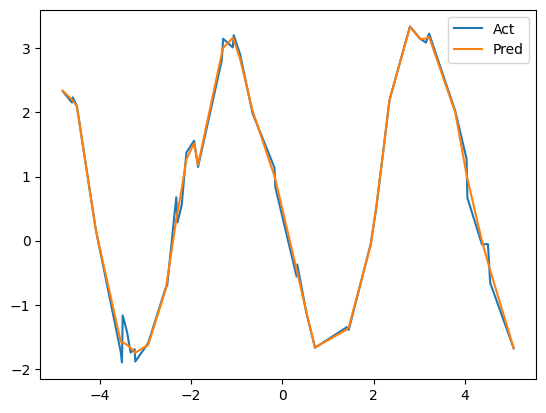

In [ ]:
test_model(f, X_train, Y_train)

MSE: 22.73503303527832


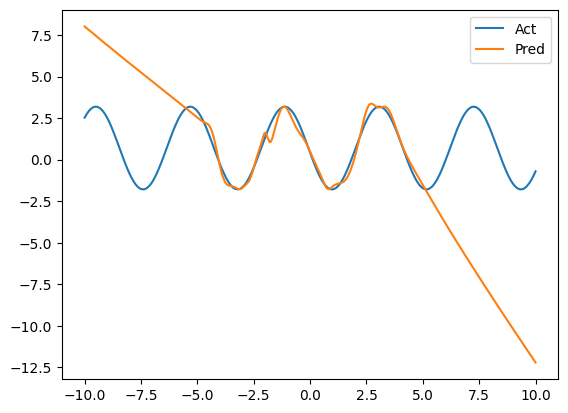

In [ ]:
test_model(f, X_test, Y_test)

t=3.20s, Epoch 100: MSE=1.6262, Phys=0.3418, LR=0.009619, Omega=-0.21, B=0.2250
t=7.05s, Epoch 200: MSE=1.6067, Phys=0.3403, LR=0.008536, Omega=-0.32, B=0.4769
t=10.34s, Epoch 300: MSE=0.4904, Phys=0.3466, LR=0.006913, Omega=-1.41, B=0.6705
t=13.82s, Epoch 400: MSE=0.2965, Phys=0.2760, LR=0.005000, Omega=-1.45, B=0.6537
t=17.70s, Epoch 500: MSE=0.2231, Phys=0.2345, LR=0.003087, Omega=-1.43, B=0.6731
t=21.29s, Epoch 600: MSE=0.2147, Phys=0.2223, LR=0.001464, Omega=-1.41, B=0.6828
t=24.71s, Epoch 700: MSE=0.2157, Phys=0.2184, LR=0.000381, Omega=-1.41, B=0.6843
t=28.05s, Epoch 800: MSE=0.2159, Phys=0.2178, LR=0.000000, Omega=-1.40, B=0.6845
t=32.07s, Epoch 900: MSE=0.2161, Phys=0.2172, LR=0.000381, Omega=-1.40, B=0.6846
t=35.44s, Epoch 1000: MSE=0.2176, Phys=0.2134, LR=0.001464, Omega=-1.40, B=0.6856
t=38.85s, Epoch 1100: MSE=0.2204, Phys=0.2086, LR=0.003087, Omega=-1.39, B=0.6874
t=42.69s, Epoch 1200: MSE=0.2330, Phys=0.1980, LR=0.005000, Omega=-1.38, B=0.6872
t=46.24s, Epoch 1300: MSE=0

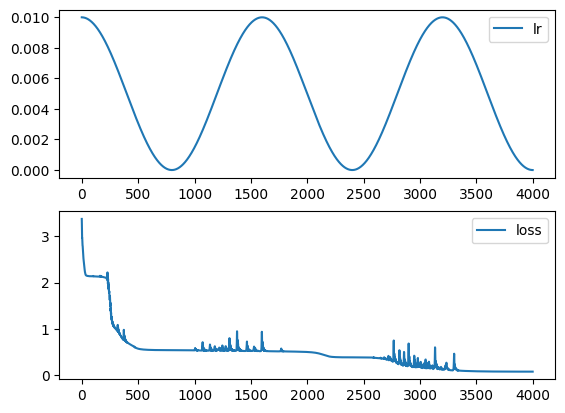

In [ ]:
# --------------------------------------------
# PINN: learnable omega and bias B
# --------------------------------------------
omega_t = torch.tensor(0.01, requires_grad=True)
B_t = torch.tensor(0.01, requires_grad=True)

lr = 0.01
num_epochs = 4000
T_scheduler = num_epochs // 5
coeff_phys = 1.5
(f, _, d2f_dx2), params = get_model_and_derivatives(device=device)
params = [*params, omega_t, B_t]

optim = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_scheduler)

X_dummy = torch.arange(-10,10,0.01).reshape(-1,1).to(device)

lrs, losses_mse, losses_phys, losses_total = [], [], [], []

start_time = time.time()
for epoch in range(num_epochs):
    optim.zero_grad()

    # Data loss
    Y_pred = f(X_train)
    loss_mse = loss_fun(Y_train, Y_pred)

    # Physics loss on dummy points
    Y_dummy_pred = f(X_dummy)
    d2Y_dummy = d2f_dx2(X_dummy).reshape(-1,1)
    phys_residual = d2Y_dummy + (omega_t**2) * (Y_dummy_pred - B_t)
    loss_phys = loss_fun(phys_residual, torch.zeros_like(phys_residual))

    # Total loss
    loss = loss_mse + coeff_phys * loss_phys
    loss.backward(retain_graph=True)
    optim.step()
    scheduler.step()

    lrs.append(scheduler.get_last_lr()[0])
    losses_mse.append(loss_mse.item())
    losses_phys.append(loss_phys.item())
    losses_total.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"t={time.time()-start_time:.2f}s, Epoch {epoch+1}: MSE={loss_mse.item():.4f}, Phys={loss_phys.item():.4f}, LR={scheduler.get_last_lr()[0]:.6f}, Omega={omega_t.item():.2f}, B={B_t.item():.4f}")

plt.subplot(2,1,1)
plt.plot(lrs, label='lr')
plt.legend()
plt.subplot(2,1,2)
plt.plot(losses_total, label='loss')
plt.legend()
plt.show()

MSE: 0.06849370151758194


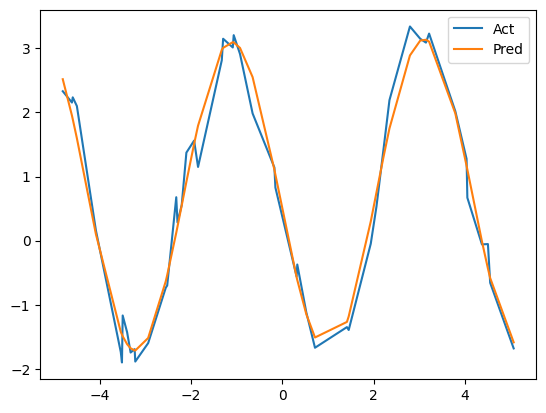

In [ ]:
test_model(f, X_train, Y_train)

MSE: 0.02117377147078514


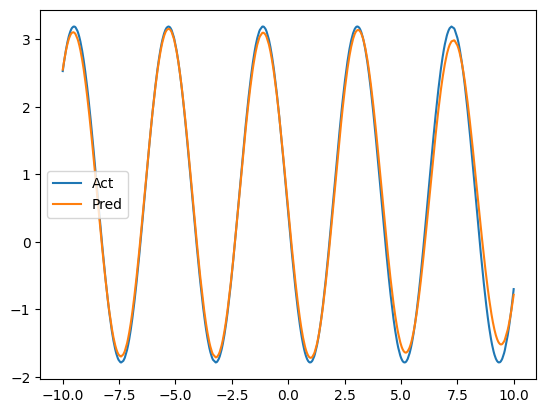

In [ ]:
test_model(f, X_test, Y_test)

## HW4:
Q: Can we use ReLU activation function in the NNs of the previous tasks? why?


## HW5:
 Following the same principles use a PINNs to learn the dynamics of simplified 2D multirotor

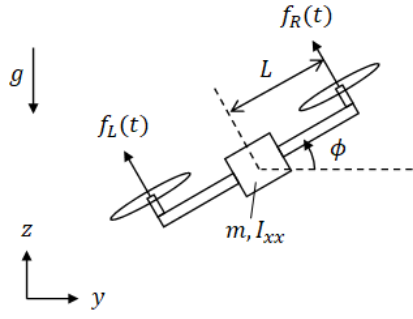

The state is $x = [y, z, \phi, v_y, v_z, \omega]$, the input is the thrust of left and right rotors $u = [f_L, f_R]$
We have the following parameters of the model (could be inaccurate)
$m = 0.35, I_{xx} = 0.005, L = 0.1, g= 9.81$

1. Derive the analytical model, define $\dot{x} = f(x, u)$

2. Create a python function to get the predicted state dynamics $\dot{x}$ based on the analytical model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.functional import jacobian
import time
import math
import matplotlib.pyplot as plt

In [ ]:
def f_anlyt(x, u):
    """
    x: (B,6) tensor [y, z, phi, vy, vz, omega]
    u: (B,2) tensor [fL, fR]
    returns xdot: (B,6)
    """
    m = 0.35
    I_xx = 0.005
    L = 0.1
    g = 9.81

    # unpack
    y = x[:, 0]
    z = x[:, 1]
    phi = x[:, 2]
    vy = x[:, 3]
    vz = x[:, 4]
    omega = x[:, 5]

    fL = u[:, 0]
    fR = u[:, 1]
    fsum = fL + fR
    fdiff = fR - fL

    # continuous time derivatives
    y_dot = vy
    z_dot = vz
    phi_dot = omega
    vy_dot = - (fsum / m) * torch.sin(phi)              # horizontal accel
    vz_dot = (fsum / m) * torch.cos(phi) - g           # vertical accel (up positive)
    omega_dot = (L * fdiff) / I_xx                     # angular accel

    xdot = torch.stack([y_dot, z_dot, phi_dot, vy_dot, vz_dot, omega_dot], dim=1)
    return xdot

In [ ]:
# Download traing and test sets
import gdown
gdown.download('https://drive.google.com/file/d/1mdCwjWupljOQH4ySLUxuTytD1Hsrzfho/view?usp=sharing', fuzzy= True)
gdown.download('https://drive.google.com/file/d/1LngllwyXvPtWD7vB-cceaFibf0UDY7N4/view?usp=sharing', fuzzy= True)

import pandas as pd

df = pd.read_csv('train.csv')

x = df[['y', 'z', 'phi', 'vy', 'vz', 'omega']].values
u = df[['ul', 'ur']].values

x_next = df[['y_next', 'z_next', 'phi_next', 'vy_next', 'vz_next', 'omega_next']].values
u_next = df[['ul_next', 'ur_next']].values

xu = np.concatenate([x, u], axis=1)
dxu = np.concatenate([x_next - x, u_next - u], axis=1)

X_train = torch.tensor(xu, dtype=torch.float32)
dX_train = torch.tensor(dxu, dtype=torch.float32)
Y_train = torch.tensor(x_next, dtype=torch.float32)

# incuce noise
X_train += 0.1 * torch.randn_like(X_train)
Y_train += 0.1 * torch.randn_like(Y_train)

# decrease number of samples
frac_samples = 10
X_train = X_train[::frac_samples]
dX_train = dX_train[::frac_samples]
Y_train = Y_train[::frac_samples]

df_test = pd.read_csv('test.csv')

x = df_test[['y', 'z', 'phi', 'vy', 'vz', 'omega']].values
u = df_test[['ul', 'ur']].values
x_next = df_test[['y_next', 'z_next', 'phi_next', 'vy_next', 'vz_next', 'omega_next']].values
xu = np.concatenate([x, u], axis=1)

X_test = torch.tensor(xu, dtype=torch.float32)
Y_test = torch.tensor(x_next, dtype=torch.float32)

X_train.shape, dX_train.shape, Y_train.shape, X_test.shape, Y_test.shape

Downloading...
From: https://drive.google.com/uc?id=1mdCwjWupljOQH4ySLUxuTytD1Hsrzfho
To: /content/train.csv
100%|██████████| 17.3M/17.3M [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LngllwyXvPtWD7vB-cceaFibf0UDY7N4
To: /content/test.csv
100%|██████████| 334k/334k [00:00<00:00, 72.5MB/s]


(torch.Size([5000, 8]),
 torch.Size([5000, 8]),
 torch.Size([5000, 6]),
 torch.Size([999, 8]),
 torch.Size([999, 6]))

3. Create a deep learning model that predict the next state $x_{k+1} = f_{NN}(x_k, u_k)$

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128], output_dim=6):
        super().__init__()
        layers = []
        D = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(D, h))
            layers.append(nn.SiLU())   # smooth activation
            D = h
        layers.append(nn.Linear(D, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, u):
        # x: (B,6), u: (B,2)
        xu = torch.cat([x, u], dim=1)
        x_next = self.net(xu)
        return x_next

4. Create the learning pipeline with the loss:

$\mathcal{L}_{d} = \frac{1}{N-1}\sum_{k=2}^{N}{\|f_{NN}(x_{k-1},
				            u_{k-1}; \theta) - x_{k}\|^2}$

$\mathcal{L}_{ph} = \frac{1}{N-1}\sum_{k=2}^{N}{\| \frac{\partial
					            f_{NN}}{\partial x}(x_k, u_k; \theta) \Delta x_k + \frac{\partial
					            f_{NN}}{\partial u}(x_k, u_k; \theta) \Delta u_k - f_{anlt}(x_k, u_k) \Delta
				            t\|^2}$

 $\mathcal{L} = \mathcal{L}_{d} + \gamma \mathcal{L}_{ph}$

Train the model on the train dataset


In [ ]:
# -------------------------------
# 3) Training pipeline implementing Ld and Lph
# -------------------------------
device = torch.device("cpu")  # change to "cuda" if available

# assume X_train, dX_train, Y_train, X_test, Y_test exist (created earlier)
# X_train rows are [x, u] concatenated; dX_train rows are [x_next - x, u_next - u]
# Y_train rows are x_next

# Move tensors to device
X_train = X_train.to(device)
dX_train = dX_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# helper to split combined xu into x and u
def split_xu(xu):
    x = xu[:, :6]
    u = xu[:, 6:8]
    return x, u

# hyperparams
lr = 1e-3
num_epochs = 600
batch_size = 128
gamma = 1.0          # weight for physics loss L_ph
dt = 0.02            # integration timestep (assumed); adjust if your data uses different dt

model = Model().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, num_epochs//5))

# Data loader (simple manual batching using indices)
N = X_train.shape[0]
indices = torch.arange(N)

history = {"ld": [], "lph": [], "total": []}

start_time = time.time()
for epoch in range(num_epochs):
    perm = torch.randperm(N)
    ld_epoch = 0.0
    lph_epoch = 0.0
    count = 0

    for i in range(0, N, batch_size):
        idx = perm[i:i+batch_size]
        xu_batch = X_train[idx]        # (B,8)
        dxu_batch = dX_train[idx]      # (B,8) where first 6 are dx = x_next - x ; last 2 are du
        y_next_batch = Y_train[idx]    # (B,6)

        x_batch, u_batch = split_xu(xu_batch)
        dx_batch = dxu_batch[:, :6].unsqueeze(-1)  # (B,6,1)
        du_batch = dxu_batch[:, 6:8].unsqueeze(-1) # (B,2,1)

        opt.zero_grad()

        # Data loss Ld
        y_pred = model(x_batch, u_batch)
        loss_d = torch.mean((y_pred - y_next_batch)**2)

        # Physics Jacobian loss Lph
        # For each sample in batch compute Jx and Ju
        # We'll compute Jacobian of model output wrt x (6x6) and wrt u (6x2)
        Bcurr = x_batch.shape[0]
        ph_res_sq_sum = 0.0

        # We need create_graph=True because we will backprop through Lph
        for b in range(Bcurr):
            xb = x_batch[b:b+1].requires_grad_(True)
            ub = u_batch[b:b+1].requires_grad_(True)

            # model returns (1,6)
            def model_xu(inp):
                # inp is concatenated (1,8)
                xin = inp[:, :6]
                uin = inp[:, 6:8]
                return model(xin, uin).squeeze(0)  # return (6,)

            inp = torch.cat([xb, ub], dim=1)  # (1,8)

            # compute jacobian: output dim 6, input dim 8 -> will produce (6,8)
            # Using autograd.functional.jacobian on the inner function
            J = jacobian(lambda z: model_xu(z), inp, create_graph=True).reshape(6, 8)  # (6,8)

            Jx = J[:, :6]   # (6,6)
            Ju = J[:, 6:8]  # (6,2)

            dx_b = dx_batch[b].to(device)   # (6,1)
            du_b = du_batch[b].to(device)   # (2,1)

            # f_anlyt at (xb, ub)
            fan = f_anlyt(xb, ub).reshape(6, 1)   # (6,1)

            # compute residual vector r = Jx * dx + Ju * du - f_anlyt * dt
            r = Jx @ dx_b + Ju @ du_b - fan * dt   # (6,1)
            ph_res_sq_sum = ph_res_sq_sum + torch.sum(r**2)

        loss_ph = ph_res_sq_sum / (Bcurr * 6.0)  # normalize by dims (you can tune normalization)
        loss = loss_d + gamma * loss_ph

        loss.backward()
        opt.step()

        ld_epoch += loss_d.item() * x_batch.size(0)
        lph_epoch += loss_ph.item() * x_batch.size(0)
        count += x_batch.size(0)

    sched.step()
    ld_epoch /= count
    lph_epoch /= count
    history["ld"].append(ld_epoch)
    history["lph"].append(lph_epoch)
    history["total"].append(ld_epoch + gamma * lph_epoch)

    if (epoch + 1) % 25 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}  Ld={ld_epoch:.6e}  Lph={lph_epoch:.6e}  Total={(ld_epoch + gamma*lph_epoch):.6e}  time={time.time()-start_time:.1f}s")

# -------------------------------
# 4) Evaluate on test set (simple MSE)
# -------------------------------
model.eval()
with torch.no_grad():
    x_test, u_test = split_xu(X_test)
    y_test_pred = model(x_test, u_test)
    mse_test = torch.mean((y_test_pred - Y_test.to(device))**2).item()
    print(f"Test MSE: {mse_test:.6e}")

# -------------------------------
# 5) Plot training curves
# -------------------------------
plt.figure(figsize=(8,4))
plt.semilogy(history["ld"], label='Ld')
plt.semilogy(history["lph"], label='Lph')
plt.semilogy(history["total"], label='Total')
plt.xlabel("Epoch")
plt.legend()
plt.title("Loss terms (log scale)")
plt.show()

KeyboardInterrupt: 

5. comapre between the analytical model and the trained model on the test dataset